# Validating a channel model IV curve with data from an experiment

In [1]:
import rickpy
rickpy.use_dev_packages(['scidash/sciunit','scidash/neuronunit','neuroml/pyNeuroML'])

# Imports and preliminaries.  
%matplotlib inline
import os,sys
import numpy as np
import quantities as pq

CW_HOME = os.path.split(os.path.realpath(os.path.pardir))[0] # Location of your ChannelWorm repo
sys.path.insert(1,CW_HOME)

from channelworm.fitter.initiators import Initiator

## Compare the IV curve predicted from the channel model to that observed from the data

In [2]:
from neuronunit.tests.channel import IVCurvePeakTest
from neuronunit.models.channel import ChannelModel

In [3]:
# Instantiate the model
channel_model_name = 'EGL-19.channel'
channel_id = 'ca_boyle'
channel_file_path = os.path.join(CW_HOME,'models','%s.nml' % channel_model_name)

model = ChannelModel(channel_file_path,channel_index=0,name=channel_model_name.split('.')[0])

In [4]:
# Get the experiment data from ChannelWorm and instantiate the test

import os, sys
import django

sys.path.append(os.path.join(CW_HOME,'channelworm')) # Change the path if needed
os.environ.setdefault(
    "DJANGO_SETTINGS_MODULE",
    "web_app.settings"
)
django.setup()

from channelworm.ion_channel.models import GraphData

doi = '10.1083/jcb.200203055'
fig = '2B'
sample_data = GraphData.objects.get(graph__experiment__reference__doi=doi, graph__figure_ref_address=fig)
obs = list(zip(*sample_data.asarray())) 
observation = {'i/C':obs[1]*pq.A/pq.F, 'v':obs[0]*pq.mV}
cell_capacitance = 1e-13 * pq.F # Capacitance is arbitrary if IV curves are scaled.  
observation['i'] = observation['i/C']*cell_capacitance

test = IVCurvePeakTest(observation, scale=True)

In [5]:
# Judge the model output against the experimental data
score = test.judge(model)
score.summarize()
print("The score was computed according to '%s' with raw value %s and pass cutoff %s" \
    % (score.description,score.raw,test.converter.cutoff))
print('The scaling factor for the model IV curve was %.3g' % score.related_data['scale_factor'])

pyNeuroML >>> Generating LEMS file to investigate ca_boyle in /Users/rgerkin/Dropbox/dev/openworm/ChannelWorm/models/EGL-19.channel.nml, -100mV->100mV, 6.3degC
pyNeuroML >>> Loading LEMS file: /Users/rgerkin/Dropbox/dev/openworm/ChannelWorm/tests/sciunit/LEMS_Test_ca_boyle.xml and running with jNeuroML
pyNeuroML >>> Executing: (java -Xmx400M  -Djava.awt.headless=true -jar  "/Users/rgerkin/Dropbox/dev/neuroml/pyNeuroML/pyneuroml/lib/jNeuroML-0.8.0-jar-with-dependencies.jar"  "/Users/rgerkin/Dropbox/dev/openworm/ChannelWorm/tests/sciunit/LEMS_Test_ca_boyle.xml"  -nogui) in directory: .
pyNeuroML >>> Command completed. Output: 
pyNeuroML >>>   jNeuroML >>   jNeuroML v0.8.0
pyNeuroML >>>   jNeuroML >>  Loading: /Users/rgerkin/Dropbox/dev/openworm/ChannelWorm/tests/sciunit/LEMS_Test_ca_boyle.xml with jLEMS, NO GUI mode...
pyNeuroML >>>   jNeuroML >>  INFO Jul 19,2016 22:30  (INFO) Loading LEMS file from: /Users/rgerkin/Dropbox/dev/openworm/ChannelWorm/tests/sciunit/LEMS_Test_ca_boyle.xml
py

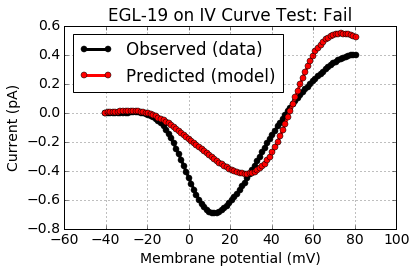

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size':14, 'lines.linewidth':3})
score.plot()
plt.tight_layout()
plt.savefig('/Users/rgerkin/Desktop/iv_curves.eps',format='eps')